# Open in Colab
<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ai-agents-the-definitive-guide/blob/main/CH02/ch02_react.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# About this notebook

This notebook is a focused walkthrough of building a minimal ReAct-style agent with **LangGraph** and **LangChain OpenAI**, including a compact internet search tool and a readable execution trace. You will see how to bind tools to a model, route between the model and tools, and print a clear transcript that mirrors ReAct action-observation-final answer patterns.

## What it shows

* **Typed agent state** that accumulates `messages` using the `add_messages` reducer.
* **Tool binding** to `gpt-4o-mini` with a single `internet_search` tool backed by SerpAPI that returns compact JSON.
* **Two node graph**

  1. `agent` node that calls the model with a system prompt
  2. `tools` node that executes any pending tool calls and returns `ToolMessage` outputs.
* **Conditional routing** that loops model → tools → model until no tool calls remain, then ends.
* **ReAct style tracing** with `print_react_trace(question)` that prints a short reasoning summary, the tool action, the observation, and the final answer.
* **Optional graph preview** using Mermaid PNG rendering.

## What you will run

1. Install a small stack: `langgraph`, `langchain-openai`, `python-dotenv`, and `google-search-results`.
2. Load environment keys from `.env` and validate `OPENAI_API_KEY`. Use `SERPAPI_API_KEY` for live search.
3. Define the `internet_search` tool that queries Google through SerpAPI and returns top results as JSON.
4. Build and compile a **StateGraph** with the `agent` and `tools` nodes and an `END` condition.
5. Call `print_react_trace("What is the weather in Zurich today?")` to see the full loop and the final reply.
6. Optionally render the graph image with Mermaid.

## How it works

* The **system prompt** instructs the assistant to keep tool calls terse and to finish with a clear final answer.
* The **agent node** invokes the model on `[SYSTEM_PROMPT] + state["messages"]`.
* The **tools node** inspects `last.tool_calls`, executes each tool by name, and emits `ToolMessage` objects with the JSON payload.
* The **router** function `should_continue` returns `"continue"` if there are tool calls, otherwise `"end"`.

## Why this pattern

* ReAct style agents are easy to reason about. The notebook prints a human legible trace without leaking chain of thought.
* LangGraph keeps control flow explicit and makes the transition function trivial to read and test.
* Tool outputs are normalized to JSON so the model can parse consistent observations.

## Extend and adapt

* Add more tools and include them in `TOOLS` and `TOOLS_BY_NAME`.
* Swap SerpAPI with another search backend that returns JSON.
* Persist memory by replacing the default in memory behavior with a checkpointer.
* Add validation or summarization nodes before the final answer if you need grounded outputs.

## Requirements and notes

* You need `OPENAI_API_KEY`. Live search requires `SERPAPI_API_KEY`.
* Internet results change over time. Expect different snippets and answers on different days.
* Mermaid rendering may require extra packages. The graph preview is optional.


# Dependencies

In [1]:
!pip install -qqq langgraph==0.6.7 langchain-openai==0.3.33 python-dotenv==1.1.1 google-search-results

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 945.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.9 MB/s eta 0:00:00


# Imports

In [ ]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

from __future__ import annotations
from typing import Annotated, Sequence, TypedDict, Dict, Any
import os
import json

from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages


# API Setup

In [ ]:
# --- API Key Setup ---
# Option 1 (preferred): create a `.env` file in your project folder with:
# OPENAI_API_KEY=your_openai_key_here
# SERPAPI_API_KEY=your_serpapi_key_here
#
# Option 2: set it directly in the notebook with magic:
# %env OPENAI_API_KEY=your_openai_key_here
# %env SERPAPI_API_KEY=your_serpapi_key_here

from dotenv import load_dotenv
import os

# Load from .env if available
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
serp_api_key = os.getenv("SERPAPI_API_KEY")


# Fallback: ask if still missing
if not OPENAI_API_KEY:
    print("⚠️ OPENAI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    OPENAI_API_KEY = input("Enter your OPENAI_API_KEY: ").strip()

if not serp_api_key:
    print("⚠️ SERPAPI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    serp_api_key = input("Enter your SERPAPI_API_KEY: ").strip()


print("✅ API keys loaded successfully!")



# Graph State

In [ ]:
class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

# LLM Setup

In [ ]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Tools

In [ ]:
@tool("internet_search")
def internet_search(query: str) -> str:
    """
    Search Google via SerpAPI for up to date information. Returns compact JSON string.
    """
    try:
        if not SERPAPI_API_KEY:
            return json.dumps({"error": "SERPAPI_API_KEY missing", "results": []})
        from serpapi import GoogleSearch  # import inside to keep import path clean
        params = {
            "engine": "google",
            "q": query,
            "api_key": SERPAPI_API_KEY,
            "num": 5,
            "hl": "en",
            "gl": "us",
        }
        data = GoogleSearch(params).get_dict()
        results = []
        for r in (data.get("organic_results") or [])[:5]:
            results.append({
                "title": r.get("title"),
                "link": r.get("link"),
                "snippet": r.get("snippet"),
                "source": r.get("source"),
            })
        return json.dumps({"results": results}, ensure_ascii=False)
    except Exception as e:
        return json.dumps({"error": str(e), "results": []})

TOOLS = [internet_search]
TOOLS_BY_NAME = {t.name: t for t in TOOLS}
model = model.bind_tools(TOOLS)


# Nodes

In [ ]:
SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a helpful AI assistant. "
        "Use tools when helpful. "
        "When you call a tool, keep your message short and focused on the action. "
        "When you finish, reply with a clear final answer for the user."
    )
)

def call_model(state: AgentState, config: RunnableConfig) -> Dict[str, Any]:
    response = model.invoke([SYSTEM_PROMPT] + state["messages"], config)
    return {"messages": [response]}

def tool_node(state: AgentState) -> Dict[str, Any]:
    """
    Execute any tool calls produced by the last AI message and return ToolMessage objects.
    """
    last = state["messages"][-1]
    outputs: list[ToolMessage] = []
    for tc in getattr(last, "tool_calls", []) or []:
        name = tc.get("name")
        args = tc.get("args") or {}
        tool_fn = TOOLS_BY_NAME.get(name)
        if not tool_fn:
            result = json.dumps({"error": f"Unknown tool {name}"})
        else:
            result = tool_fn.invoke(args)
        outputs.append(
            ToolMessage(
                content=result,
                name=name,
                tool_call_id=tc.get("id"),
            )
        )
    return {"messages": outputs}

def should_continue(state: AgentState) -> str:
    last = state["messages"][-1]
    if getattr(last, "tool_calls", None):
        return "continue"
    return "end"

# Graph

In [ ]:
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue": "tools", "end": END},
)

workflow.add_edge("tools", "agent")
graph = workflow.compile()


# ReAct style trace

In [ ]:
def _shorten(text: str, n: int = 280) -> str:
    if len(text) <= n:
        return text
    return text[: n - 3] + "..."

def print_react_trace(question: str) -> str:
    """
    Run the graph and print a concise ReAct style transcript.
    Returns the final answer string.
    """
    print("> Entering new ReAct trace...")
    print(f"Question: {question}\n")

    final_answer = None
    inputs = {"messages": [("user", question)]}

    for step in graph.stream(inputs, stream_mode="values"):
        msg = step["messages"][-1]

        # AI proposes a tool call
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            # Avoid chain of thought leakage. Provide a short reasoning summary instead.
            print("Reasoning Summary: selecting a tool based on the query")
            for tc in msg.tool_calls:
                name = tc.get("name")
                args = tc.get("args") or {}
                print("Action:")
                print("```")
                print(json.dumps({"action": name, "action_input": args}, indent=2))
                print("```")
                print()

        # Tool result
        elif isinstance(msg, ToolMessage):
            try:
                payload = json.loads(msg.content) if msg.content else {}
            except Exception:
                payload = {"raw": msg.content}
            results = payload.get("results", [])
            if results:
                top = results[0]
                obs = {
                    "title": top.get("title"),
                    "snippet": _shorten(top.get("snippet", "")),
                    "link": top.get("link"),
                    "source": top.get("source"),
                }
            else:
                obs = payload if payload else {"note": "empty tool response"}
            print("Observation:")
            print("```")
            print(_shorten(json.dumps(obs, indent=2)))
            print("```")
            print()

        # Final AI reply
        else:
            # This fires both mid run and at the end. The conditional edge ends when no tool_calls.
            if not getattr(msg, "tool_calls", None):
                final_answer = msg.content
                print("Final Answer:", final_answer)
                print("\n> Finished trace.\n")

    return final_answer


# Run the Graph

In [ ]:

if __name__ == "__main__":
    print_react_trace("What is the weather in Zurich today?")


> Entering new ReAct trace...
Question: What is the weather in Zurich today?

Final Answer: What is the weather in Zurich today?

> Finished trace.

Reasoning Summary: selecting a tool based on the query
Action:
```
{
  "action": "internet_search",
  "action_input": {
    "query": "Zurich weather today"
  }
}
```

Observation:
```
{
  "title": "Zurich, Zurich, Switzerland Weather Forecast",
  "snippet": "Hourly Weather \u00b7 1 PM 74\u00b0. rain drop 0% \u00b7 2 PM 80\u00b0. rain drop 0% \u00b7 3 PM 82\u00b0. rain drop 0% \u00b7 4 PM 83\u00b0. rain drop 0% \u00b7 5 PM 84\u00b0. rain drop 0% \u00b7 6 PM ...
```

Final Answer: Today in Zurich, the weather is mostly sunny with a high of 82°F (about 28°C) and a low of 62°F (about 17°C). Winds are light from the southwest at 6 mph. 

For more details, you can check the full forecast [here](https://www.accuweather.com/en/ch/zurich/316622/weather-forecast/316622).

> Finished trace.



# Plot the Graph

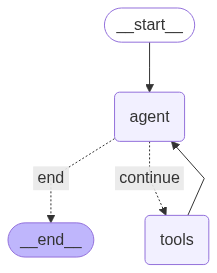

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### NOTE: Sometimes Mermaid doesn't work online

In that case you can do: `print(hier.get_graph().draw_ascii())`
or: `print(hier.get_graph().draw_mermaid())`

and then go to [Mermaid Live Editor](https://mermaid.live/edit#pako:eNp1kmFrgzAQhv9KuMFoQZ3a1bRp6Zf1J-zTliGpJiqkicS4rSv974ux2PXDEOLd8d77HJecodAlBwJhGFJVaCWailCFkJD6q6iZsT5DqOjNJydINoozQ5WXV4a1NXrdb6iiNs876-R5Pnvftrsp2z61u485IUQ0prOD8NCfuJn5cz7kHZfSFcafr7gxrNG-egvnI4SrckL4eAJINvpPaBSGO-Q5m4nrayNqc49CYYQe1aFrN6VWfIxQ5NRXzr9yqXX7R34DjhhPvPWNNm7Wbs8FKrlgvbRINFKSB5GKWIhg2HFY86aqLUmi9K7Bb9HLQ92yorEnEt8Jhi1c7Q7ikImCKgigMk0JRDDZ8QCO3BzZkMN5uFsKtuZHToG48DoQBaourq9l6k3rIxBretdpdF_Vk0_flszyfcPcO7hJ3LK4edG9skCS2FsAOcO3yxY4wqslXiySZJk9JzgL4AQkfY6jeJllGcZr963SSwA_HhpH2TJJsjRe4XWCFyleX34BzNfoqQ) to past this in to plot the Graph.